In [1]:
IRT_DIMS = 1
DATASET = 'test_matrix'    

In [2]:
import sys, os, shutil
import pickle
import time
import numpy as np
from utils import (mymode, load_data_heterogeneous, create_data_object_heterogeneous)
import seaborn as sns

from IRT import MIRT_2PL
from Heterogeneous_embedder import EmbedderHeterogeneous, train_embedder_heterogeneous, test_embedder_heterogeneous
from manage_experiments import perform_cross_validation

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [3]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# Initialise
parameters = {
    'df_name': None,
    'epochs': 10000,
    'learning_rate': 0.005,
    'weight_decay': 0,
    'early_stopping': 200,
    'n_splits': 10,
    'device': 'cuda:0',
    'batch_size': 1024
    }

if IRT_DIMS > 0:
    parameters['model_type'] = 'IRT'
    parameters['hidden_dims'] = IRT_DIMS
    parameters['lambda1'] = 0
    parameters['lambda2'] = 0
    OUTNAME = 'IRT'
else:
    parameters['model_type'] = 'GNN'
    parameters['hidden_dims'] = [16,8]
    OUTNAME = 'SAGE' 
    
print(parameters)
print(dataset)

In [6]:
DATA_FILE = 'data/mindsteps_set_' + DATASET
df = load_data_heterogeneous(DATA_FILE)
data, df_student, df_item, df_edge = create_data_object_heterogeneous(df, return_aux_data=True)

(327841, 24)


In [7]:
df.columns

Index(['studentId', 'code', 'motherTongue', 'Gender', 'scale', 'matrix',
       'IRT_difficulty', 'topic', 'responseformat', 'textlength', 'score',
       'age', 'grade', 'viewingTime', 'timestamp', 'useCase', 'assessmentId',
       'ability', 'frequency', 'previous_sessions', 'years_from_start',
       'matdiff', 'matcode', 'domain'],
      dtype='object')

In [8]:
df.head()

,studentId,code,motherTongue,Gender,scale,matrix,IRT_difficulty,topic,responseformat,textlength,...,timestamp,useCase,assessmentId,ability,frequency,previous_sessions,years_from_start,matdiff,matcode,domain
0,0,0,0.0,0.0,dles,D.2.B.1.f,0.268748,Zeitungsartikel,NaN,NaN,...,7.643058e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d
1,0,1,0.0,0.0,dles,D.2.B.1.h,1.217388,Textsorten erkennen,single choice,NaN,...,7.643061e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d
2,0,2,0.0,0.0,dles,D.2.B.1.h,1.584145,Wissenstexte: Mix,single choice,NaN,...,7.845624e-312,ms-kber,E109B3CDD31EDCFE7F48665587372C60A3FAEBB8571544...,2.421279,4.137915,6,1.45,,,d
3,0,3,0.0,0.0,dles,D.2.B.1.h,1.584145,Wissenstexte: Mix,single choice,NaN,...,7.851631e-312,ms-kber,319A0FE3AFDC0A30C4C1B26577B5B19FE66E918A181354...,2.174872,7.432378,11,1.48,,,d
4,0,4,0.0,0.0,dles,D.2.C.1.h,1.172410,Geschichten lang,single choice,NaN,...,7.643059e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d


edge_dim = data['student', 'responds', 'item'].edge_attr.shape[1]
if IRT_DIMS > 0:
    model = MIRT_2PL(IRT_DIMS, edge_dim, data)
else:
    model = EmbedderHeterogeneous( 
        n_students =  data['student'].x.size(0),
        n_items = data['item'].x.size(0),
        student_inchannel = data['student'].x.size(1),
        item_inchannel = data['item'].x.size(1),
        hidden_channels=parameters['hidden_dims'],
        edge_channel=edge_dim,
        metadata=data.metadata()
        ).to(device)
    
model = model.to(device)

In [9]:
output_dict, model = perform_cross_validation(data, parameters, save_embeddings=True, save_subgraph=True, final_fit=True)

0it [00:00, ?it/s]
  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  1.93it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.25it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.24it/s]

100%|██████████| 4/4 [00:00<00:00,  4.26it/s]



Epoch: 001, Loss: 30857.0527, Val: 0.5059, Test: 0.5044



  0%|          | 1/10000 [00:01<4:14:36,  1.53s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.92it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.95it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.00it/s]

100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

  0%|          | 2/10000 [00:02<2:58:17,  1.07s/it]


Epoch: 002, Loss: 29775.3535, Val: 0.5071, Test: 0.5038




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.28it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.62it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.58it/s]

100%|██████████| 4/4 [00:00<00:00,  6.99it/s]

  0%|          | 3/10000 [00:03<2:46:15,  1.00it/s]


Epoch: 003, Loss: 29618.4023, Val: 0.5087, Test: 0.5062




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.93it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.33it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.07it/s]

100%|██████████| 4/4 [00:00<00:00,  7.61it/s]



Epoch: 004, Loss: 29196.5996, Val: 0.5088, Test: 0.5076



  0%|          | 4/10000 [00:04<2:40:16,  1.04it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.79it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.07it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.72it/s]

100%|██████████| 4/4 [00:00<00:00,  6.14it/s]

  0%|          | 5/10000 [00:04<2:29:19,  1.12it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.50it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.00it/s]

100%|██████████| 4/4 [00:00<00:00,  8.50it/s]



Epoch: 006, Loss: 27024.7852, Val: 0.5116, Test: 0.5102



  0%|          | 6/10000 [00:05<2:23:23,  1.16it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.36it/s]

100%|██████████| 4/4 [00:00<00:00, 11.05it/s]

  0%|          | 7/10000 [00:06<2:04:21,  1.34it/s]


Epoch: 007, Loss: 26839.3887, Val: 0.5150, Test: 0.5142




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.87it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.86it/s]

100%|██████████| 4/4 [00:00<00:00, 10.19it/s]

  0%|          | 8/10000 [00:06<2:00:08,  1.39it/s]


Epoch: 008, Loss: 26324.9922, Val: 0.5153, Test: 0.5157




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.78it/s]

100%|██████████| 4/4 [00:00<00:00, 11.83it/s]



Epoch: 009, Loss: 25136.0566, Val: 0.5189, Test: 0.5153



  0%|          | 9/10000 [00:07<1:54:29,  1.45it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.81it/s]

100%|██████████| 4/4 [00:00<00:00,  9.86it/s]

  0%|          | 10/10000 [00:08<1:49:28,  1.52it/s]


Epoch: 010, Loss: 24843.2539, Val: 0.5205, Test: 0.5167




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.18it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.18it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.50it/s]

100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

  0%|          | 11/10000 [00:09<2:05:54,  1.32it/s]


Epoch: 011, Loss: 23769.8438, Val: 0.5242, Test: 0.5194




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.54it/s]

100%|██████████| 4/4 [00:00<00:00, 11.24it/s]



Epoch: 012, Loss: 23407.5254, Val: 0.5255, Test: 0.5231



  0%|          | 12/10000 [00:09<2:00:21,  1.38it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.81it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.46it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.98it/s]

100%|██████████| 4/4 [00:00<00:00,  6.63it/s]

  0%|          | 13/10000 [00:10<2:04:05,  1.34it/s]


Epoch: 013, Loss: 23228.2637, Val: 0.5273, Test: 0.5257




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.77it/s]

100%|██████████| 4/4 [00:00<00:00,  8.76it/s]

  0%|          | 14/10000 [00:11<2:05:50,  1.32it/s]


Epoch: 014, Loss: 22526.5020, Val: 0.5280, Test: 0.5271




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.98it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.00it/s]

100%|██████████| 4/4 [00:00<00:00,  6.96it/s]



Epoch: 015, Loss: 21501.1152, Val: 0.5301, Test: 0.5279



  0%|          | 15/10000 [00:12<2:13:00,  1.25it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.30it/s]

100%|██████████| 4/4 [00:00<00:00, 12.68it/s]



Epoch: 016, Loss: 21207.9551, Val: 0.5312, Test: 0.5300



  0%|          | 16/10000 [00:12<2:04:58,  1.33it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.58it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.90it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.70it/s]

100%|██████████| 4/4 [00:00<00:00,  5.15it/s]

  0%|          | 17/10000 [00:13<2:14:14,  1.24it/s]


Epoch: 017, Loss: 21150.7070, Val: 0.5326, Test: 0.5315




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.37it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.44it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.25it/s]

100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

  0%|          | 18/10000 [00:14<2:18:56,  1.20it/s]


Epoch: 018, Loss: 20116.3477, Val: 0.5352, Test: 0.5337




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.42it/s]

100%|██████████| 4/4 [00:00<00:00,  9.73it/s]



Epoch: 019, Loss: 19382.2520, Val: 0.5372, Test: 0.5342



  0%|          | 19/10000 [00:15<2:13:46,  1.24it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.91it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.80it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.21it/s]

100%|██████████| 4/4 [00:00<00:00,  6.44it/s]

  0%|          | 20/10000 [00:16<2:16:41,  1.22it/s]


Epoch: 020, Loss: 19698.1543, Val: 0.5394, Test: 0.5359




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.14it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.32it/s]

100%|██████████| 4/4 [00:00<00:00, 10.40it/s]

  0%|          | 21/10000 [00:17<2:14:32,  1.24it/s]


Epoch: 021, Loss: 19032.6133, Val: 0.5425, Test: 0.5378




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.86it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.68it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.44it/s]

100%|██████████| 4/4 [00:00<00:00,  6.98it/s]



Epoch: 022, Loss: 18518.1465, Val: 0.5453, Test: 0.5396



  0%|          | 22/10000 [00:17<2:20:31,  1.18it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.21it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.59it/s]

100%|██████████| 4/4 [00:00<00:00,  8.37it/s]

  0%|          | 23/10000 [00:18<2:09:18,  1.29it/s]


Epoch: 023, Loss: 18135.3320, Val: 0.5475, Test: 0.5417




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.47it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.67it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.70it/s]

100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

  0%|          | 24/10000 [00:19<2:19:31,  1.19it/s]


Epoch: 024, Loss: 17956.7402, Val: 0.5489, Test: 0.5433




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.70it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.51it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.57it/s]

100%|██████████| 4/4 [00:00<00:00,  6.41it/s]



Epoch: 025, Loss: 17655.4375, Val: 0.5514, Test: 0.5452



  0%|          | 25/10000 [00:20<2:27:13,  1.13it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.98it/s]

100%|██████████| 4/4 [00:00<00:00,  9.38it/s]

  0%|          | 26/10000 [00:21<2:13:48,  1.24it/s]


Epoch: 026, Loss: 17100.6602, Val: 0.5536, Test: 0.5462




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.15it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.98it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.05it/s]

100%|██████████| 4/4 [00:00<00:00,  7.24it/s]

  0%|          | 27/10000 [00:22<2:17:49,  1.21it/s]


Epoch: 027, Loss: 16893.6875, Val: 0.5562, Test: 0.5485




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.56it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.85it/s]

100%|██████████| 4/4 [00:00<00:00,  8.14it/s]



Epoch: 028, Loss: 16324.2539, Val: 0.5585, Test: 0.5506



  0%|          | 28/10000 [00:22<2:19:09,  1.19it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.75it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.66it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.09it/s]

100%|██████████| 4/4 [00:00<00:00,  6.64it/s]



Epoch: 029, Loss: 16097.9814, Val: 0.5598, Test: 0.5523



  0%|          | 29/10000 [00:23<2:29:26,  1.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.04it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.18it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.34it/s]

100%|██████████| 4/4 [00:00<00:00,  6.75it/s]

  0%|          | 30/10000 [00:24<2:24:29,  1.15it/s]


Epoch: 030, Loss: 15599.4219, Val: 0.5620, Test: 0.5542




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.93it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.49it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.06it/s]

100%|██████████| 4/4 [00:00<00:00,  6.35it/s]

  0%|          | 31/10000 [00:25<2:30:40,  1.10it/s]


Epoch: 031, Loss: 15150.6064, Val: 0.5642, Test: 0.5558




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.43it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.21it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.75it/s]

100%|██████████| 4/4 [00:00<00:00,  6.23it/s]



Epoch: 032, Loss: 15128.1875, Val: 0.5659, Test: 0.5579



  0%|          | 32/10000 [00:26<2:35:39,  1.07it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.34it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.92it/s]

100%|██████████| 4/4 [00:00<00:00,  9.91it/s]

  0%|          | 33/10000 [00:27<2:18:26,  1.20it/s]


Epoch: 033, Loss: 14505.6250, Val: 0.5682, Test: 0.5596




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.91it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.22it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.98it/s]

100%|██████████| 4/4 [00:00<00:00,  6.54it/s]

  0%|          | 34/10000 [00:28<2:23:52,  1.15it/s]


Epoch: 034, Loss: 14107.4170, Val: 0.5701, Test: 0.5606




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.73it/s]

100%|██████████| 4/4 [00:00<00:00, 11.51it/s]



Epoch: 035, Loss: 13682.6982, Val: 0.5711, Test: 0.5626



  0%|          | 35/10000 [00:28<2:14:55,  1.23it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.69it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.93it/s]

100%|██████████| 4/4 [00:00<00:00,  9.00it/s]

  0%|          | 36/10000 [00:29<2:03:41,  1.34it/s]


Epoch: 036, Loss: 13692.6670, Val: 0.5727, Test: 0.5642




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.97it/s]

100%|██████████| 4/4 [00:00<00:00, 10.64it/s]

  0%|          | 37/10000 [00:30<1:59:41,  1.39it/s]


Epoch: 037, Loss: 13255.9355, Val: 0.5751, Test: 0.5657




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.58it/s]

100%|██████████| 4/4 [00:00<00:00, 10.01it/s]



Epoch: 038, Loss: 12957.5488, Val: 0.5764, Test: 0.5670



  0%|          | 38/10000 [00:30<1:57:40,  1.41it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.20it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.49it/s]

100%|██████████| 4/4 [00:00<00:00,  9.95it/s]

  0%|          | 39/10000 [00:31<1:50:11,  1.51it/s]


Epoch: 039, Loss: 12850.1641, Val: 0.5779, Test: 0.5688




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.96it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.57it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.30it/s]

100%|██████████| 4/4 [00:00<00:00,  9.34it/s]

  0%|          | 40/10000 [00:32<1:55:53,  1.43it/s]


Epoch: 040, Loss: 12527.4160, Val: 0.5795, Test: 0.5712




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.21it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.43it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.38it/s]

100%|██████████| 4/4 [00:00<00:00,  6.88it/s]



Epoch: 041, Loss: 12305.2012, Val: 0.5807, Test: 0.5735



  0%|          | 41/10000 [00:33<2:07:12,  1.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.02it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.90it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.01it/s]

100%|██████████| 4/4 [00:00<00:00,  6.49it/s]



Epoch: 042, Loss: 11837.2607, Val: 0.5827, Test: 0.5750



  0%|          | 42/10000 [00:34<2:17:24,  1.21it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.62it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.84it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.93it/s]

100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

  0%|          | 43/10000 [00:34<2:14:10,  1.24it/s]


Epoch: 043, Loss: 11546.1963, Val: 0.5837, Test: 0.5767




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.20it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.51it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.21it/s]

100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

  0%|          | 44/10000 [00:35<2:21:28,  1.17it/s]


Epoch: 044, Loss: 11200.5127, Val: 0.5853, Test: 0.5788




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.44it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.95it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.09it/s]

100%|██████████| 4/4 [00:00<00:00,  6.55it/s]

  0%|          | 45/10000 [00:36<2:22:33,  1.16it/s]


Epoch: 045, Loss: 11190.0176, Val: 0.5874, Test: 0.5816




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.93it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.47it/s]

100%|██████████| 4/4 [00:00<00:00,  9.76it/s]

  0%|          | 46/10000 [00:37<2:07:20,  1.30it/s]


Epoch: 046, Loss: 10779.5586, Val: 0.5896, Test: 0.5826




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.54it/s]

100%|██████████| 4/4 [00:00<00:00, 11.43it/s]

  0%|          | 47/10000 [00:37<2:00:26,  1.38it/s]


Epoch: 047, Loss: 10916.3564, Val: 0.5919, Test: 0.5840




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.63it/s]

100%|██████████| 4/4 [00:00<00:00,  8.96it/s]



Epoch: 048, Loss: 10497.0586, Val: 0.5940, Test: 0.5851



  0%|          | 48/10000 [00:38<2:03:00,  1.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.67it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.27it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.44it/s]

100%|██████████| 4/4 [00:00<00:00,  6.83it/s]

  0%|          | 49/10000 [00:39<2:04:58,  1.33it/s]


Epoch: 049, Loss: 10214.6816, Val: 0.5954, Test: 0.5867




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.25it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.70it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.15it/s]

100%|██████████| 4/4 [00:00<00:00,  6.29it/s]

  0%|          | 50/10000 [00:40<2:17:40,  1.20it/s]


Epoch: 050, Loss: 10073.1611, Val: 0.5971, Test: 0.5880




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.02it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.76it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.64it/s]

100%|██████████| 4/4 [00:00<00:00,  7.06it/s]



Epoch: 051, Loss: 9771.4775, Val: 0.5998, Test: 0.5906



  1%|          | 51/10000 [00:41<2:21:52,  1.17it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.99it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.88it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.23it/s]

100%|██████████| 4/4 [00:00<00:00,  6.60it/s]

  1%|          | 52/10000 [00:42<2:18:39,  1.20it/s]


Epoch: 052, Loss: 9680.7500, Val: 0.6011, Test: 0.5911




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.95it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.97it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.76it/s]

100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

  1%|          | 53/10000 [00:43<2:25:50,  1.14it/s]


Epoch: 053, Loss: 9680.9805, Val: 0.6025, Test: 0.5928




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.89it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.69it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.88it/s]

100%|██████████| 4/4 [00:00<00:00,  6.22it/s]



Epoch: 054, Loss: 9230.6768, Val: 0.6033, Test: 0.5941



  1%|          | 54/10000 [00:44<2:31:19,  1.10it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.33it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.02it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.15it/s]

100%|██████████| 4/4 [00:00<00:00,  6.33it/s]



Epoch: 055, Loss: 9373.4854, Val: 0.6042, Test: 0.5957



  1%|          | 55/10000 [00:45<2:34:29,  1.07it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.78it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.29it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.23it/s]

100%|██████████| 4/4 [00:00<00:00,  5.63it/s]

  1%|          | 56/10000 [00:46<2:32:56,  1.08it/s]


Epoch: 056, Loss: 8926.1035, Val: 0.6060, Test: 0.5966




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.44it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.62it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.84it/s]

100%|██████████| 4/4 [00:00<00:00,  6.16it/s]

  1%|          | 57/10000 [00:47<2:37:08,  1.05it/s]


Epoch: 057, Loss: 8836.4668, Val: 0.6077, Test: 0.5986




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.57it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.17it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.12it/s]

100%|██████████| 4/4 [00:00<00:00,  6.50it/s]



Epoch: 058, Loss: 8660.0352, Val: 0.6092, Test: 0.6010



  1%|          | 58/10000 [00:48<2:38:15,  1.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.89it/s]

100%|██████████| 4/4 [00:00<00:00, 11.74it/s]

  1%|          | 59/10000 [00:48<2:15:52,  1.22it/s]


Epoch: 059, Loss: 8548.6592, Val: 0.6104, Test: 0.6034




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.65it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.04it/s]

100%|██████████| 4/4 [00:00<00:00, 10.56it/s]

  1%|          | 60/10000 [00:49<2:08:15,  1.29it/s]


Epoch: 060, Loss: 8172.5186, Val: 0.6124, Test: 0.6050




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.92it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.38it/s]

100%|██████████| 4/4 [00:00<00:00, 10.04it/s]



Epoch: 061, Loss: 8034.1660, Val: 0.6134, Test: 0.6070



  1%|          | 61/10000 [00:49<2:04:37,  1.33it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.51it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.08it/s]

100%|██████████| 4/4 [00:00<00:00, 10.43it/s]

  1%|          | 62/10000 [00:50<1:54:17,  1.45it/s]


Epoch: 062, Loss: 7736.4023, Val: 0.6158, Test: 0.6080




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.91it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.22it/s]

100%|██████████| 4/4 [00:00<00:00,  8.35it/s]

  1%|          | 63/10000 [00:51<1:59:50,  1.38it/s]


Epoch: 063, Loss: 7630.4629, Val: 0.6171, Test: 0.6100




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.37it/s]

100%|██████████| 4/4 [00:00<00:00, 10.94it/s]



Epoch: 064, Loss: 7701.5376, Val: 0.6181, Test: 0.6119



  1%|          | 64/10000 [00:51<1:56:20,  1.42it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.91it/s]

100%|██████████| 4/4 [00:00<00:00, 10.77it/s]

  1%|          | 65/10000 [00:52<1:48:51,  1.52it/s]


Epoch: 065, Loss: 7516.2793, Val: 0.6182, Test: 0.6143




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.50it/s]

100%|██████████| 4/4 [00:00<00:00, 11.09it/s]

  1%|          | 66/10000 [00:53<1:49:12,  1.52it/s]


Epoch: 066, Loss: 7323.0806, Val: 0.6192, Test: 0.6154




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.98it/s]

100%|██████████| 4/4 [00:00<00:00,  9.96it/s]



Epoch: 067, Loss: 7192.5693, Val: 0.6203, Test: 0.6173



  1%|          | 67/10000 [00:53<1:51:46,  1.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.77it/s]

100%|██████████| 4/4 [00:00<00:00, 10.60it/s]



Epoch: 068, Loss: 7187.7012, Val: 0.6210, Test: 0.6172



  1%|          | 68/10000 [00:54<1:51:57,  1.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.80it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.65it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.26it/s]

100%|██████████| 4/4 [00:00<00:00,  6.86it/s]

  1%|          | 69/10000 [00:55<1:55:26,  1.43it/s]


Epoch: 069, Loss: 7082.6274, Val: 0.6223, Test: 0.6183




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.40it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.01it/s]

100%|██████████| 4/4 [00:00<00:00, 10.49it/s]

  1%|          | 70/10000 [00:55<1:54:14,  1.45it/s]


Epoch: 070, Loss: 6915.2700, Val: 0.6234, Test: 0.6191




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.36it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.72it/s]

100%|██████████| 4/4 [00:00<00:00,  9.62it/s]

  1%|          | 71/10000 [00:56<1:53:41,  1.46it/s]


Epoch: 071, Loss: 6737.7666, Val: 0.6236, Test: 0.6207




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.82it/s]

100%|██████████| 4/4 [00:00<00:00, 10.72it/s]

  1%|          | 72/10000 [00:57<1:45:23,  1.57it/s]


Epoch: 072, Loss: 6585.6675, Val: 0.6251, Test: 0.6216




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.21it/s]

100%|██████████| 4/4 [00:00<00:00, 10.58it/s]

  1%|          | 73/10000 [00:57<1:47:52,  1.53it/s]


Epoch: 073, Loss: 6443.5181, Val: 0.6269, Test: 0.6230




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.51it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.88it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.50it/s]

100%|██████████| 4/4 [00:00<00:00,  7.18it/s]



Epoch: 074, Loss: 6419.9541, Val: 0.6279, Test: 0.6244



  1%|          | 74/10000 [00:58<2:02:17,  1.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.31it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.39it/s]

100%|██████████| 4/4 [00:00<00:00,  7.30it/s]

  1%|          | 75/10000 [00:59<2:00:02,  1.38it/s]


Epoch: 075, Loss: 6241.9189, Val: 0.6291, Test: 0.6262




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.87it/s]

100%|██████████| 4/4 [00:00<00:00, 10.69it/s]

  1%|          | 76/10000 [01:00<1:58:45,  1.39it/s]


Epoch: 076, Loss: 6152.9766, Val: 0.6307, Test: 0.6264




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.53it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.62it/s]

100%|██████████| 4/4 [00:00<00:00,  6.63it/s]



Epoch: 077, Loss: 5913.0854, Val: 0.6312, Test: 0.6280



  1%|          | 77/10000 [01:01<2:43:20,  1.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.47it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.10it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.43it/s]

100%|██████████| 4/4 [00:00<00:00,  7.00it/s]

  1%|          | 78/10000 [01:02<2:32:42,  1.08it/s]


Epoch: 078, Loss: 5857.7969, Val: 0.6322, Test: 0.6290




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.21it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.09it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.68it/s]

100%|██████████| 4/4 [00:00<00:00,  6.08it/s]

  1%|          | 79/10000 [01:03<2:37:32,  1.05it/s]


Epoch: 079, Loss: 5913.7544, Val: 0.6336, Test: 0.6299




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.06it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.74it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.80it/s]

100%|██████████| 4/4 [00:00<00:00,  6.03it/s]



Epoch: 080, Loss: 5649.6602, Val: 0.6343, Test: 0.6314



  1%|          | 80/10000 [01:04<2:41:13,  1.03it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.32it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.05it/s]

100%|██████████| 4/4 [00:00<00:00,  6.84it/s]

  1%|          | 81/10000 [01:05<2:31:43,  1.09it/s]


Epoch: 081, Loss: 5655.9902, Val: 0.6351, Test: 0.6331




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.89it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.10it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.76it/s]

100%|██████████| 4/4 [00:00<00:00,  8.07it/s]

  1%|          | 82/10000 [01:06<2:27:32,  1.12it/s]


Epoch: 082, Loss: 5439.1201, Val: 0.6360, Test: 0.6344




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.25it/s]

100%|██████████| 4/4 [00:00<00:00, 13.65it/s]

  1%|          | 83/10000 [01:06<2:13:22,  1.24it/s]


Epoch: 083, Loss: 5500.3330, Val: 0.6369, Test: 0.6356




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.65it/s]

100%|██████████| 4/4 [00:00<00:00, 13.44it/s]



Epoch: 084, Loss: 5240.7275, Val: 0.6379, Test: 0.6370



  1%|          | 84/10000 [01:07<2:03:25,  1.34it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.56it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.33it/s]

100%|██████████| 4/4 [00:00<00:00, 10.15it/s]

  1%|          | 85/10000 [01:07<1:53:06,  1.46it/s]


Epoch: 085, Loss: 5284.4526, Val: 0.6390, Test: 0.6385




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.02it/s]

100%|██████████| 4/4 [00:00<00:00, 10.25it/s]

  1%|          | 86/10000 [01:08<1:55:31,  1.43it/s]


Epoch: 086, Loss: 5221.0166, Val: 0.6397, Test: 0.6393




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.70it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.56it/s]

100%|██████████| 4/4 [00:00<00:00,  7.64it/s]



Epoch: 087, Loss: 5134.4062, Val: 0.6400, Test: 0.6402



  1%|          | 87/10000 [01:09<2:02:42,  1.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.74it/s]

100%|██████████| 4/4 [00:00<00:00, 10.18it/s]

  1%|          | 88/10000 [01:10<1:54:14,  1.45it/s]


Epoch: 088, Loss: 4898.7075, Val: 0.6406, Test: 0.6410




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.33it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.45it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.43it/s]

100%|██████████| 4/4 [00:00<00:00,  6.86it/s]

  1%|          | 89/10000 [01:11<2:05:28,  1.32it/s]


Epoch: 089, Loss: 4844.9692, Val: 0.6419, Test: 0.6417




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.62it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.61it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.57it/s]

100%|██████████| 4/4 [00:00<00:00,  6.96it/s]



Epoch: 090, Loss: 4725.3950, Val: 0.6431, Test: 0.6427



  1%|          | 90/10000 [01:11<2:12:34,  1.25it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  8.58it/s]

100%|██████████| 4/4 [00:00<00:00,  8.38it/s]

  1%|          | 91/10000 [01:12<2:05:09,  1.32it/s]


Epoch: 091, Loss: 4633.4141, Val: 0.6432, Test: 0.6435




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.13it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.97it/s]

100%|██████████| 4/4 [00:00<00:00,  8.43it/s]

  1%|          | 92/10000 [01:13<2:07:44,  1.29it/s]


Epoch: 092, Loss: 4639.9673, Val: 0.6442, Test: 0.6439




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.59it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.48it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.08it/s]

100%|██████████| 4/4 [00:00<00:00,  6.21it/s]



Epoch: 093, Loss: 4543.1738, Val: 0.6447, Test: 0.6439



  1%|          | 93/10000 [01:14<2:19:51,  1.18it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.26it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.88it/s]

100%|██████████| 4/4 [00:00<00:00,  8.17it/s]

  1%|          | 94/10000 [01:15<2:11:50,  1.25it/s]


Epoch: 094, Loss: 4516.0562, Val: 0.6456, Test: 0.6443




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.73it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.46it/s]

100%|██████████| 4/4 [00:00<00:00,  7.67it/s]

  1%|          | 95/10000 [01:15<2:11:41,  1.25it/s]


Epoch: 095, Loss: 4435.7715, Val: 0.6467, Test: 0.6447




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.99it/s]

100%|██████████| 4/4 [00:00<00:00,  9.99it/s]

  1%|          | 96/10000 [01:16<2:08:30,  1.28it/s]


Epoch: 096, Loss: 4323.8608, Val: 0.6473, Test: 0.6455




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.80it/s]

100%|██████████| 4/4 [00:00<00:00,  9.98it/s]



Epoch: 097, Loss: 4187.9844, Val: 0.6481, Test: 0.6458



  1%|          | 97/10000 [01:17<2:04:16,  1.33it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.22it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.01it/s]

100%|██████████| 4/4 [00:00<00:00,  9.83it/s]

  1%|          | 98/10000 [01:17<1:55:09,  1.43it/s]


Epoch: 098, Loss: 4059.4436, Val: 0.6484, Test: 0.6469




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.09it/s]

100%|██████████| 4/4 [00:00<00:00, 12.76it/s]

  1%|          | 99/10000 [01:18<1:52:09,  1.47it/s]


Epoch: 099, Loss: 4155.6562, Val: 0.6494, Test: 0.6485




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.76it/s]

100%|██████████| 4/4 [00:00<00:00, 10.64it/s]



Epoch: 100, Loss: 4077.8201, Val: 0.6501, Test: 0.6489



  1%|          | 100/10000 [01:19<1:52:18,  1.47it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.44it/s]

100%|██████████| 4/4 [00:00<00:00, 11.10it/s]

  1%|          | 101/10000 [01:19<1:43:40,  1.59it/s]


Epoch: 101, Loss: 4001.8645, Val: 0.6509, Test: 0.6496




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.74it/s]

100%|██████████| 4/4 [00:00<00:00, 10.84it/s]

  1%|          | 102/10000 [01:20<1:46:51,  1.54it/s]


Epoch: 102, Loss: 3969.4067, Val: 0.6513, Test: 0.6503




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.75it/s]

100%|██████████| 4/4 [00:00<00:00, 12.28it/s]



Epoch: 103, Loss: 3812.0171, Val: 0.6521, Test: 0.6508



  1%|          | 103/10000 [01:21<1:50:33,  1.49it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.36it/s]

100%|██████████| 4/4 [00:00<00:00, 13.66it/s]

  1%|          | 104/10000 [01:21<1:40:04,  1.65it/s]


Epoch: 104, Loss: 3810.7134, Val: 0.6533, Test: 0.6519




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.71it/s]

100%|██████████| 4/4 [00:00<00:00, 12.32it/s]

  1%|          | 105/10000 [01:22<1:43:55,  1.59it/s]


Epoch: 105, Loss: 3703.9729, Val: 0.6539, Test: 0.6530




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.35it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.53it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.67it/s]

100%|██████████| 4/4 [00:00<00:00,  7.03it/s]

  1%|          | 106/10000 [01:22<1:45:46,  1.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.48it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.41it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.42it/s]

100%|██████████| 4/4 [00:00<00:00,  6.91it/s]

  1%|          | 107/10000 [01:23<1:59:05,  1.38it/s]


Epoch: 107, Loss: 3628.1707, Val: 0.6546, Test: 0.6537




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.62it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.51it/s]

100%|██████████| 4/4 [00:00<00:00, 10.18it/s]



Epoch: 108, Loss: 3650.5483, Val: 0.6550, Test: 0.6542



  1%|          | 108/10000 [01:24<1:56:47,  1.41it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.40it/s]

100%|██████████| 4/4 [00:00<00:00, 10.30it/s]



Epoch: 109, Loss: 3627.4109, Val: 0.6556, Test: 0.6547



  1%|          | 109/10000 [01:25<1:57:39,  1.40it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.58it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.86it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.79it/s]

100%|██████████| 4/4 [00:00<00:00,  7.00it/s]

  1%|          | 110/10000 [01:25<1:59:39,  1.38it/s]


Epoch: 110, Loss: 3548.8901, Val: 0.6560, Test: 0.6554




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.47it/s]

100%|██████████| 4/4 [00:00<00:00, 11.78it/s]

  1%|          | 111/10000 [01:26<1:54:55,  1.43it/s]


Epoch: 111, Loss: 3484.3843, Val: 0.6567, Test: 0.6562




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.53it/s]

100%|██████████| 4/4 [00:00<00:00, 12.10it/s]

  1%|          | 112/10000 [01:27<1:40:31,  1.64it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.36it/s]

100%|██████████| 4/4 [00:00<00:00, 11.74it/s]

  1%|          | 113/10000 [01:27<1:40:53,  1.63it/s]


Epoch: 113, Loss: 3396.6052, Val: 0.6569, Test: 0.6581




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.51it/s]

100%|██████████| 4/4 [00:00<00:00, 10.69it/s]



Epoch: 114, Loss: 3222.5173, Val: 0.6582, Test: 0.6584



  1%|          | 114/10000 [01:28<1:43:01,  1.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.50it/s]

100%|██████████| 4/4 [00:00<00:00, 10.52it/s]

  1%|          | 115/10000 [01:28<1:38:24,  1.67it/s]


Epoch: 115, Loss: 3220.4624, Val: 0.6588, Test: 0.6587




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.74it/s]

100%|██████████| 4/4 [00:00<00:00, 10.28it/s]

  1%|          | 116/10000 [01:29<1:42:18,  1.61it/s]


Epoch: 116, Loss: 3228.8875, Val: 0.6591, Test: 0.6591




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.54it/s]

100%|██████████| 4/4 [00:00<00:00, 10.51it/s]

  1%|          | 117/10000 [01:30<1:44:13,  1.58it/s]


Epoch: 117, Loss: 3080.2065, Val: 0.6595, Test: 0.6597




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.71it/s]

100%|██████████| 4/4 [00:00<00:00, 13.41it/s]

  1%|          | 118/10000 [01:30<1:35:40,  1.72it/s]


Epoch: 118, Loss: 3067.1128, Val: 0.6602, Test: 0.6602




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.15it/s]

100%|██████████| 4/4 [00:00<00:00, 10.33it/s]

  1%|          | 119/10000 [01:31<1:39:54,  1.65it/s]


Epoch: 119, Loss: 3074.5325, Val: 0.6604, Test: 0.6609




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.40it/s]

100%|██████████| 4/4 [00:00<00:00, 11.85it/s]



Epoch: 120, Loss: 2948.6960, Val: 0.6612, Test: 0.6613



  1%|          | 120/10000 [01:31<1:41:05,  1.63it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.27it/s]

100%|██████████| 4/4 [00:00<00:00, 10.66it/s]

  1%|          | 121/10000 [01:32<1:36:55,  1.70it/s]


Epoch: 121, Loss: 2933.2988, Val: 0.6616, Test: 0.6623




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.88it/s]

100%|██████████| 4/4 [00:00<00:00, 10.76it/s]

  1%|          | 122/10000 [01:33<1:39:48,  1.65it/s]


Epoch: 122, Loss: 2964.3508, Val: 0.6617, Test: 0.6626




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.19it/s]

100%|██████████| 4/4 [00:00<00:00, 10.77it/s]

  1%|          | 123/10000 [01:33<1:45:23,  1.56it/s]


Epoch: 123, Loss: 2886.3125, Val: 0.6619, Test: 0.6630




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.14it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.31it/s]

100%|██████████| 4/4 [00:00<00:00,  9.30it/s]

  1%|          | 124/10000 [01:34<1:48:15,  1.52it/s]


Epoch: 124, Loss: 2843.3022, Val: 0.6626, Test: 0.6637




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.60it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.75it/s]

100%|██████████| 4/4 [00:00<00:00,  8.14it/s]

  1%|▏         | 125/10000 [01:35<1:49:00,  1.51it/s]


Epoch: 125, Loss: 2772.1228, Val: 0.6632, Test: 0.6633




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.76it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.60it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.75it/s]

100%|██████████| 4/4 [00:00<00:00,  7.09it/s]

  1%|▏         | 126/10000 [01:36<2:01:16,  1.36it/s]


Epoch: 126, Loss: 2742.7336, Val: 0.6635, Test: 0.6634




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.00it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.72it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.13it/s]

100%|██████████| 4/4 [00:00<00:00,  7.27it/s]



Epoch: 127, Loss: 2764.5884, Val: 0.6645, Test: 0.6635



  1%|▏         | 127/10000 [01:36<2:08:01,  1.29it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.61it/s]

100%|██████████| 4/4 [00:00<00:00, 10.92it/s]

  1%|▏         | 128/10000 [01:37<1:54:32,  1.44it/s]


Epoch: 128, Loss: 2669.2632, Val: 0.6648, Test: 0.6642




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.35it/s]

100%|██████████| 4/4 [00:00<00:00,  9.70it/s]

  1%|▏         | 129/10000 [01:38<1:57:28,  1.40it/s]


Epoch: 129, Loss: 2652.3379, Val: 0.6652, Test: 0.6648




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.91it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.93it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.89it/s]

100%|██████████| 4/4 [00:00<00:00,  7.28it/s]



Epoch: 130, Loss: 2642.9158, Val: 0.6652, Test: 0.6657



  1%|▏         | 130/10000 [01:39<2:06:49,  1.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.95it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.21it/s]

100%|██████████| 4/4 [00:00<00:00, 10.55it/s]

  1%|▏         | 131/10000 [01:39<1:51:34,  1.47it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.22it/s]

100%|██████████| 4/4 [00:00<00:00, 10.59it/s]



Epoch: 132, Loss: 2564.5312, Val: 0.6658, Test: 0.6674



  1%|▏         | 132/10000 [01:40<1:54:07,  1.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.29it/s]

100%|██████████| 4/4 [00:00<00:00, 11.40it/s]

  1%|▏         | 133/10000 [01:40<1:44:47,  1.57it/s]


Epoch: 133, Loss: 2496.3640, Val: 0.6663, Test: 0.6675




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.95it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.03it/s]

100%|██████████| 4/4 [00:00<00:00,  9.56it/s]

  1%|▏         | 134/10000 [01:41<1:47:36,  1.53it/s]


Epoch: 134, Loss: 2502.3733, Val: 0.6672, Test: 0.6684




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.59it/s]

100%|██████████| 4/4 [00:00<00:00, 11.25it/s]



Epoch: 135, Loss: 2520.7915, Val: 0.6684, Test: 0.6689



  1%|▏         | 135/10000 [01:42<1:46:22,  1.55it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.80it/s]

100%|██████████| 4/4 [00:00<00:00, 13.65it/s]



Epoch: 136, Loss: 2395.1313, Val: 0.6689, Test: 0.6691



  1%|▏         | 136/10000 [01:42<1:45:24,  1.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.03it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.31it/s]

100%|██████████| 4/4 [00:00<00:00,  9.16it/s]

  1%|▏         | 137/10000 [01:43<1:42:52,  1.60it/s]


Epoch: 137, Loss: 2344.8391, Val: 0.6696, Test: 0.6694




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.81it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.81it/s]

100%|██████████| 4/4 [00:00<00:00,  9.74it/s]

  1%|▏         | 138/10000 [01:44<1:48:55,  1.51it/s]


Epoch: 138, Loss: 2341.6960, Val: 0.6701, Test: 0.6695




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.23it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.49it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  8.31it/s]

100%|██████████| 4/4 [00:00<00:00,  8.37it/s]

  1%|▏         | 139/10000 [01:44<1:44:32,  1.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.60it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.71it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.39it/s]

100%|██████████| 4/4 [00:00<00:00,  6.87it/s]

  1%|▏         | 140/10000 [01:45<1:54:30,  1.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.91it/s]

100%|██████████| 4/4 [00:00<00:00,  9.68it/s]

  1%|▏         | 141/10000 [01:46<1:48:07,  1.52it/s]


Epoch: 141, Loss: 2235.7964, Val: 0.6703, Test: 0.6697




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.69it/s]

100%|██████████| 4/4 [00:00<00:00, 11.66it/s]

  1%|▏         | 142/10000 [01:46<1:42:07,  1.61it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.22it/s]

100%|██████████| 4/4 [00:00<00:00,  9.33it/s]

  1%|▏         | 143/10000 [01:47<1:40:21,  1.64it/s]


Epoch: 143, Loss: 2225.2520, Val: 0.6705, Test: 0.6705




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.66it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.51it/s]

100%|██████████| 4/4 [00:00<00:00,  9.31it/s]

  1%|▏         | 144/10000 [01:47<1:42:13,  1.61it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.15it/s]

100%|██████████| 4/4 [00:00<00:00, 12.26it/s]

  1%|▏         | 145/10000 [01:48<1:31:23,  1.80it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.18it/s]

100%|██████████| 4/4 [00:00<00:00, 10.26it/s]



Epoch: 146, Loss: 2116.3071, Val: 0.6709, Test: 0.6724



  1%|▏         | 146/10000 [01:48<1:37:24,  1.69it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00, 10.00it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.36it/s]

100%|██████████| 4/4 [00:00<00:00,  9.04it/s]

  1%|▏         | 147/10000 [01:49<1:37:56,  1.68it/s]


Epoch: 147, Loss: 2051.1333, Val: 0.6712, Test: 0.6729




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.30it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.10it/s]

100%|██████████| 4/4 [00:00<00:00, 10.14it/s]

  1%|▏         | 148/10000 [01:50<1:42:56,  1.60it/s]


Epoch: 148, Loss: 2144.7153, Val: 0.6712, Test: 0.6731




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.48it/s]

100%|██████████| 4/4 [00:00<00:00, 10.61it/s]

  1%|▏         | 149/10000 [01:50<1:34:05,  1.75it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.32it/s]

100%|██████████| 4/4 [00:00<00:00, 11.27it/s]

  2%|▏         | 150/10000 [01:51<1:37:55,  1.68it/s]


Epoch: 150, Loss: 2040.6788, Val: 0.6713, Test: 0.6728




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.84it/s]

100%|██████████| 4/4 [00:00<00:00, 10.90it/s]

  2%|▏         | 151/10000 [01:52<1:40:01,  1.64it/s]


Epoch: 151, Loss: 1964.0939, Val: 0.6720, Test: 0.6736




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.84it/s]

100%|██████████| 4/4 [00:00<00:00, 11.08it/s]

  2%|▏         | 152/10000 [01:52<1:35:27,  1.72it/s]


Epoch: 152, Loss: 2004.5826, Val: 0.6720, Test: 0.6737




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.58it/s]

100%|██████████| 4/4 [00:00<00:00, 11.16it/s]

  2%|▏         | 153/10000 [01:53<1:39:09,  1.65it/s]


Epoch: 153, Loss: 1971.9169, Val: 0.6724, Test: 0.6743




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.48it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.40it/s]

100%|██████████| 4/4 [00:00<00:00, 10.43it/s]

  2%|▏         | 154/10000 [01:53<1:43:03,  1.59it/s]


Epoch: 154, Loss: 1870.1674, Val: 0.6725, Test: 0.6749




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.64it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.35it/s]

100%|██████████| 4/4 [00:00<00:00,  9.79it/s]

  2%|▏         | 155/10000 [01:54<1:35:44,  1.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.94it/s]

100%|██████████| 4/4 [00:00<00:00, 10.44it/s]

  2%|▏         | 156/10000 [01:55<1:40:06,  1.64it/s]


Epoch: 156, Loss: 1857.8092, Val: 0.6727, Test: 0.6756




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.56it/s]

100%|██████████| 4/4 [00:00<00:00,  9.74it/s]



Epoch: 157, Loss: 1769.2284, Val: 0.6727, Test: 0.6762



  2%|▏         | 157/10000 [01:55<1:43:55,  1.58it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.53it/s]

100%|██████████| 4/4 [00:00<00:00, 10.12it/s]

  2%|▏         | 158/10000 [01:56<1:40:20,  1.63it/s]


Epoch: 158, Loss: 1795.6079, Val: 0.6732, Test: 0.6768




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.92it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.17it/s]

100%|██████████| 4/4 [00:00<00:00, 10.21it/s]

  2%|▏         | 159/10000 [01:56<1:44:23,  1.57it/s]


Epoch: 159, Loss: 1829.1746, Val: 0.6734, Test: 0.6770




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.54it/s]

100%|██████████| 4/4 [00:00<00:00, 10.75it/s]

  2%|▏         | 160/10000 [01:57<1:35:38,  1.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.30it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.67it/s]

100%|██████████| 4/4 [00:00<00:00,  8.03it/s]

  2%|▏         | 161/10000 [01:58<1:43:49,  1.58it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.09it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.83it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.74it/s]

100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

  2%|▏         | 162/10000 [01:58<1:49:21,  1.50it/s]


Epoch: 162, Loss: 1764.6724, Val: 0.6737, Test: 0.6769




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.58it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.38it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.34it/s]

100%|██████████| 4/4 [00:00<00:00,  6.76it/s]

  2%|▏         | 163/10000 [01:59<2:00:11,  1.36it/s]


Epoch: 163, Loss: 1729.2334, Val: 0.6746, Test: 0.6766




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.79it/s]

100%|██████████| 4/4 [00:00<00:00, 10.26it/s]

  2%|▏         | 164/10000 [02:00<1:47:58,  1.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.65it/s]

100%|██████████| 4/4 [00:00<00:00, 11.37it/s]

  2%|▏         | 165/10000 [02:00<1:44:20,  1.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.77it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.42it/s]

100%|██████████| 4/4 [00:00<00:00, 10.34it/s]

  2%|▏         | 166/10000 [02:01<1:36:02,  1.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.06it/s]

100%|██████████| 4/4 [00:00<00:00, 10.39it/s]

  2%|▏         | 167/10000 [02:01<1:30:14,  1.82it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.89it/s]

100%|██████████| 4/4 [00:00<00:00, 10.36it/s]

  2%|▏         | 168/10000 [02:02<1:32:34,  1.77it/s]

  0%|      


Epoch: 173, Loss: 1520.8563, Val: 0.6746, Test: 0.6784




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.67it/s]

100%|██████████| 4/4 [00:00<00:00, 10.73it/s]



Epoch: 174, Loss: 1549.9220, Val: 0.6747, Test: 0.6786



  2%|▏         | 174/10000 [02:05<1:35:03,  1.72it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.62it/s]

100%|██████████| 4/4 [00:00<00:00, 10.70it/s]

  2%|▏         | 175/10000 [02:06<1:31:51,  1.78it/s]


Epoch: 175, Loss: 1505.6820, Val: 0.6751, Test: 0.6789




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.13it/s]

100%|██████████| 4/4 [00:00<00:00, 12.47it/s]

  2%|▏         | 176/10000 [02:06<1:33:53,  1.74it/s]


Epoch: 176, Loss: 1502.5651, Val: 0.6755, Test: 0.6793




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.99it/s]

100%|██████████| 4/4 [00:00<00:00, 10.93it/s]

  2%|▏         | 177/10000 [02:07<1:28:13,  1.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.85it/s]

100%|██████████| 4/4 [00:00<00:00, 10.15it/s]

  2%|▏         | 178/10000 [02:07<1:35:36,  1.71it/s]


Epoch: 178, Loss: 1467.8671, Val: 0.6759, Test: 0.6800




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.58it/s]

100%|██████████| 4/4 [00:00<00:00, 12.60it/s]

  2%|▏         | 179/10000 [02:08<1:27:01,  1.88it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.42it/s]

100%|██████████| 4/4 [00:00<00:00, 11.41it/s]

  2%|▏         | 180/10000 [02:08<1:33:11,  1.76it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.31it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.83it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.73it/s]

100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

  2%|▏         | 181/10000 [02:09<1:37:16,  1.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.15it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.07it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.90it/s]

100%|██████████| 4/4 [00:00<00:00,  7.03it/s]

  2%|▏         | 182/10000 [02:10<1:40:53,  1.62it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/


Epoch: 183, Loss: 1412.9866, Val: 0.6761, Test: 0.6803




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.31it/s]

100%|██████████| 4/4 [00:00<00:00, 11.41it/s]



Epoch: 184, Loss: 1381.4504, Val: 0.6765, Test: 0.6802



  2%|▏         | 184/10000 [02:11<1:54:29,  1.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.15it/s]

100%|██████████| 4/4 [00:00<00:00, 12.97it/s]

  2%|▏         | 185/10000 [02:12<1:42:44,  1.59it/s]


Epoch: 185, Loss: 1374.1766, Val: 0.6768, Test: 0.6798




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.19it/s]

100%|██████████| 4/4 [00:00<00:00, 11.71it/s]

  2%|▏         | 186/10000 [02:12<1:42:07,  1.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.08it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.27it/s]

100%|██████████| 4/4 [00:00<00:00,  9.68it/s]

  2%|▏         | 187/10000 [02:13<1:36:17,  1.70it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.60it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.38it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.57it/s]

100%|██████████| 4/4 [00:00<00:00,  6.73it/s]

  2%|▏         | 188/10000 [02:14<1:41:10,  1.62it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.09it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.10it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.07it/s]

100%|██████████| 4/4 [00:00<00:00,  6.56it/s]

  2%|▏         | 189/10000 [02:15<1:53:57,  1.43it/s]

  0%|      


Epoch: 193, Loss: 1281.5990, Val: 0.6769, Test: 0.6791



  2%|▏         | 193/10000 [02:18<2:08:38,  1.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.52it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.75it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.29it/s]

100%|██████████| 4/4 [00:00<00:00,  6.71it/s]

  2%|▏         | 194/10000 [02:18<2:08:28,  1.27it/s]


Epoch: 194, Loss: 1301.2153, Val: 0.6772, Test: 0.6794




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.60it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.69it/s]

100%|██████████| 4/4 [00:00<00:00, 10.12it/s]

  2%|▏         | 195/10000 [02:19<2:00:52,  1.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.55it/s]

100%|██████████| 4/4 [00:00<00:00, 12.63it/s]

  2%|▏         | 196/10000 [02:19<1:44:57,  1.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.62it/s]

100%|██████████| 4/4 [00:00<00:00, 12.07it/s]



Epoch: 197, Loss: 1219.8767, Val: 0.6775, Test: 0.6795



  2%|▏         | 197/10000 [02:20<1:45:49,  1.54it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.08it/s]

100%|██████████| 4/4 [00:00<00:00, 12.25it/s]

  2%|▏         | 198/10000 [02:21<1:37:13,  1.68it/s]


Epoch: 198, Loss: 1241.4382, Val: 0.6778, Test: 0.6797




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.96it/s]

100%|██████████| 4/4 [00:00<00:00, 11.10it/s]

  2%|▏         | 199/10000 [02:21<1:36:17,  1.70it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.72it/s]

100%|██████████| 4/4 [00:00<00:00, 11.64it/s]

  2%|▏         | 200/10000 [02:22<1:27:46,  1.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.38it/s]

100%|██████████| 4/4 [00:00<00:00, 12.38it/s]

  2%|▏         | 201/10000 [02:22<1:21:04,  2.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.02it/s]

100%|██████████| 4/4 [00:00<00:00, 12.61it/s]

  2%|▏         | 202/10000 [02:23<1:25:25,  1.91it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.28it/s]

100%|██████████| 4/4 [00:00<00:00, 12.67it/s]

  2%|▏         | 203/10000 [02:23<1:18:50,  2.07it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/


Epoch: 216, Loss: 1052.3818, Val: 0.6779, Test: 0.6810




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.32it/s]

100%|██████████| 4/4 [00:00<00:00, 13.05it/s]



Epoch: 217, Loss: 984.8741, Val: 0.6785, Test: 0.6810



  2%|▏         | 217/10000 [02:30<1:34:15,  1.73it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.39it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.89it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.43it/s]

100%|██████████| 4/4 [00:00<00:00,  6.96it/s]

  2%|▏         | 218/10000 [02:31<1:43:19,  1.58it/s]


Epoch: 218, Loss: 1005.2806, Val: 0.6786, Test: 0.6809




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.01it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.15it/s]

100%|██████████| 4/4 [00:00<00:00,  8.15it/s]

  2%|▏         | 219/10000 [02:32<1:49:43,  1.49it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.99it/s]

100%|██████████| 4/4 [00:00<00:00, 13.07it/s]

  2%|▏         | 220/10000 [02:32<1:36:36,  1.69it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.96it/s]

100%|██████████| 4/4 [00:00<00:00, 13.32it/s]

  2%|▏         | 221/10000 [02:33<1:25:53,  1.90it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.71it/s]

100%|██████████| 4/4 [00:00<00:00, 12.99it/s]

  2%|▏         | 222/10000 [02:33<1:28:06,  1.85it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.39it/s]

100%|██████████| 4/4 [00:00<00:00, 12.67it/s]

  2%|▏         | 223/10000 [02:34<1:20:39,  2.02it/s]

  0%|      


Epoch: 229, Loss: 937.4452, Val: 0.6788, Test: 0.6813




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.23it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.23it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.03it/s]

100%|██████████| 4/4 [00:00<00:00,  6.39it/s]

  2%|▏         | 230/10000 [02:38<1:53:11,  1.44it/s]


Epoch: 230, Loss: 918.3197, Val: 0.6792, Test: 0.6815




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.77it/s]

100%|██████████| 4/4 [00:00<00:00, 10.58it/s]



Epoch: 231, Loss: 918.6617, Val: 0.6794, Test: 0.6815



  2%|▏         | 231/10000 [02:38<1:55:54,  1.40it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.39it/s]

100%|██████████| 4/4 [00:00<00:00, 12.71it/s]



Epoch: 232, Loss: 890.3242, Val: 0.6799, Test: 0.6815



  2%|▏         | 232/10000 [02:39<1:52:34,  1.45it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.58it/s]

100%|██████████| 4/4 [00:00<00:00, 13.52it/s]

  2%|▏         | 233/10000 [02:39<1:36:48,  1.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.81it/s]

100%|██████████| 4/4 [00:00<00:00, 12.92it/s]



Epoch: 234, Loss: 906.3899, Val: 0.6800, Test: 0.6811



  2%|▏         | 234/10000 [02:40<1:39:31,  1.64it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.35it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.84it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.33it/s]

100%|██████████| 4/4 [00:00<00:00,  7.63it/s]

  2%|▏         | 235/10000 [02:41<1:40:08,  1.63it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.72it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.77it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.80it/s]

100%|██████████| 4/4 [00:00<00:00,  7.17it/s]



Epoch: 236, Loss: 873.7134, Val: 0.6801, Test: 0.6810



  2%|▏         | 236/10000 [02:42<1:54:59,  1.42it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.73it/s]

100%|██████████| 4/4 [00:00<00:00, 12.95it/s]

  2%|▏         | 237/10000 [02:42<1:38:59,  1.64it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.71it/s]

100%|██████████| 4/4 [00:00<00:00,  8.53it/s]



Epoch: 238, Loss: 823.0075, Val: 0.6804, Test: 0.6809



  2%|▏         | 238/10000 [02:43<1:49:04,  1.49it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.55it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.71it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.69it/s]

100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

  2%|▏         | 239/10000 [02:44<1:48:40,  1.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.83it/s]

100%|██████████| 4/4 [00:00<00:00, 11.53it/s]

  2%|▏         | 240/10000 [02:44<1:36:55,  1.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.87it/s]

100%|██████████| 4/4 [00:00<00:00,  9.99it/s]

  2%|▏         | 241/10000 [02:45<1:37:50,  1.66it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.38it/s]

100%|██████████| 4/4 [00:00<00:00, 10.58it/s]

  2%|▏         | 242/10000 [02:45<1:30:16,  1.80it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.68it/s]

100%|███████


Epoch: 243, Loss: 829.6898, Val: 0.6804, Test: 0.6812




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.96it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.68it/s]

100%|██████████| 4/4 [00:00<00:00, 10.83it/s]

  2%|▏         | 244/10000 [02:46<1:28:39,  1.83it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.33it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.99it/s]

100%|██████████| 4/4 [00:00<00:00,  7.66it/s]

  2%|▏         | 245/10000 [02:47<1:31:08,  1.78it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.54it/s]

100%|██████████| 4/4 [00:00<00:00, 10.95it/s]

  2%|▏         | 246/10000 [02:47<1:38:17,  1.65it/s]


Epoch: 246, Loss: 789.0851, Val: 0.6808, Test: 0.6817




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.95it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.75it/s]

100%|██████████| 4/4 [00:00<00:00,  8.16it/s]




Epoch: 247, Loss: 841.8812, Val: 0.6810, Test: 0.6819


  2%|▏         | 247/10000 [02:48<1:47:38,  1.51it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.78it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.17it/s]

100%|██████████| 4/4 [00:00<00:00,  9.06it/s]

  2%|▏         | 248/10000 [02:49<1:41:26,  1.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.05it/s]

100%|██████████| 4/4 [00:00<00:00, 10.31it/s]

  2%|▏         | 249/10000 [02:49<1:33:56,  1.73it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.18it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.58it/s]

100%|██████████| 4/4 [00:00<00:00,  8.73it/s]

  2%|▎         | 250/10000 [02:50<1:39:23,  1.64it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.66it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.10it/s]

100%|██████████| 4/4 [00:00<00:00, 10.41it/s]

  3%|▎         | 251/10000 [02:50<1:32:47,  1.75it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌     


Epoch: 265, Loss: 695.3098, Val: 0.6813, Test: 0.6823




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.45it/s]

100%|██████████| 4/4 [00:00<00:00, 12.39it/s]

  3%|▎         | 266/10000 [02:59<1:34:16,  1.72it/s]


Epoch: 266, Loss: 693.8492, Val: 0.6815, Test: 0.6826




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.57it/s]

100%|██████████| 4/4 [00:00<00:00, 12.88it/s]

  3%|▎         | 267/10000 [03:00<1:25:07,  1.91it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.94it/s]

100%|██████████| 4/4 [00:00<00:00, 11.83it/s]

  3%|▎         | 268/10000 [03:00<1:31:13,  1.78it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.07it/s]

100%|██████████| 4/4 [00:00<00:00, 11.44it/s]

  3%|▎         | 269/10000 [03:01<1:24:52,  1.91it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.38it/s]

100%|██████████| 4/4 [00:00<00:00, 11.84it/s]



Epoch: 270, Loss: 679.3574, Val: 0.6818, Test: 0.6824



  3%|▎         | 270/10000 [03:02<1:33:34,  1.73it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.86it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.74it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.35it/s]

100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

  3%|▎         | 271/10000 [03:02<1:34:50,  1.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.10it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.73it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.51it/s]

100%|██████████| 4/4 [00:00<00:00,  7.11it/s]



Epoch: 272, Loss: 668.9722, Val: 0.6819, Test: 0.6820



  3%|▎         | 272/10000 [03:03<1:52:45,  1.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.95it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.57it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.22it/s]

100%|██████████| 4/4 [00:00<00:00,  7.65it/s]

  3%|▎         | 273/10000 [03:04<1:48:53,  1.49it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.78it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.69it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.66it/s]

100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

  3%|▎         | 274/10000 [03:04<1:48:13,  1.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.63it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.66it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.72it/s]

100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

  3%|▎         | 275/10000 [03:05<1:56:27,  1.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.68it/s]

 50%|█████  


Epoch: 277, Loss: 643.1763, Val: 0.6819, Test: 0.6826




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.66it/s]

100%|██████████| 4/4 [00:00<00:00, 12.07it/s]

  3%|▎         | 278/10000 [03:07<1:47:35,  1.51it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.31it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.00it/s]

100%|██████████| 4/4 [00:00<00:00, 10.71it/s]

  3%|▎         | 279/10000 [03:08<1:45:37,  1.53it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.64it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.97it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.51it/s]

100%|██████████| 4/4 [00:00<00:00,  6.87it/s]

  3%|▎         | 280/10000 [03:09<1:46:59,  1.51it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.03it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.98it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.82it/s]

100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

  3%|▎         | 281/10000 [03:09<1:46:25,  1.52it/s]

  0%|      

100%|██████████| 4/4 [00:00<00:00, 10.84it/s]

  3%|▎         | 340/10000 [03:45<1:20:55,  1.99it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.00it/s]

100%|██████████| 4/4 [00:00<00:00, 11.53it/s]

  3%|▎         | 341/10000 [03:45<1:17:15,  2.08it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.40it/s]

100%|██████████| 4/4 [00:00<00:00, 11.63it/s]

  3%|▎         | 342/10000 [03:46<1:14:08,  2.17it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.84it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.11it/s]

100%|██████████| 4/4 [00:00<00:00,  9.71it/s]

  3%|▎         | 343/10000 [03:46<1:22:35,  1.95it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.63it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.62it/s]

100%|██████████| 4/4 [00:00<00:00, 10.19it/s]

  3%|▎         | 344/10000 [03:47<1:20:31,  2.00it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████   


Epoch: 378, Loss: 354.4500, Val: 0.6820, Test: 0.6831




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.86it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.80it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.75it/s]

100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

  4%|▍         | 379/10000 [04:10<1:46:32,  1.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.48it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.49it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.59it/s]

100%|██████████| 4/4 [00:00<00:00,  7.01it/s]

  4%|▍         | 380/10000 [04:11<1:54:30,  1.40it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.75it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.72it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.80it/s]

100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

  4%|▍         | 381/10000 [04:12<1:51:39,  1.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.12it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.74it/s]

 75%|███████▌  | 3/

100%|██████████| 4/4 [00:00<00:00,  9.84it/s]

  4%|▍         | 449/10000 [04:47<1:26:13,  1.85it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.85it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.98it/s]

100%|██████████| 4/4 [00:00<00:00, 10.16it/s]

  4%|▍         | 450/10000 [04:48<1:22:33,  1.93it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.04it/s]

100%|██████████| 4/4 [00:00<00:00,  9.64it/s]

  5%|▍         | 451/10000 [04:48<1:22:11,  1.94it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.12it/s]

100%|██████████| 4/4 [00:00<00:00, 11.01it/s]

  5%|▍         | 452/10000 [04:49<1:25:40,  1.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.60it/s]

100%|██████████| 4/4 [00:00<00:00, 10.45it/s]

  5%|▍         | 453/10000 [04:49<1:21:41,  1.95it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.76it/s]

 50%|█████   


Epoch: 476, Loss: 224.8955, Val: 0.6820, Test: 0.6829




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.48it/s]

100%|██████████| 4/4 [00:00<00:00, 10.01it/s]

  5%|▍         | 477/10000 [05:03<1:37:26,  1.63it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.86it/s]

100%|██████████| 4/4 [00:00<00:00, 10.05it/s]

  5%|▍         | 478/10000 [05:04<1:31:27,  1.74it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.22it/s]

100%|██████████| 4/4 [00:00<00:00, 10.39it/s]

  5%|▍         | 479/10000 [05:04<1:26:05,  1.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.11it/s]

100%|██████████| 4/4 [00:00<00:00,  9.66it/s]

  5%|▍         | 480/10000 [05:05<1:31:12,  1.74it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.83it/s]

100%|██████████| 4/4 [00:00<00:00, 10.10it/s]

  5%|▍         | 481/10000 [05:05<1:26:44,  1.83it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/


Epoch: 482, Loss: 219.4419, Val: 0.6822, Test: 0.6823



  5%|▍         | 482/10000 [05:06<1:33:53,  1.69it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.94it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.33it/s]

100%|██████████| 4/4 [00:00<00:00,  9.75it/s]

  5%|▍         | 483/10000 [05:06<1:29:52,  1.76it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.45it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.22it/s]

100%|██████████| 4/4 [00:00<00:00,  9.70it/s]

  5%|▍         | 484/10000 [05:07<1:33:56,  1.69it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.65it/s]

100%|██████████| 4/4 [00:00<00:00, 11.61it/s]

  5%|▍         | 485/10000 [05:07<1:26:17,  1.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.67it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.55it/s]

100%|██████████| 4/4 [00:00<00:00,  9.61it/s]

  5%|▍         | 486/10000 [05:08<1:24:34,  1.87it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌    

100%|██████████| 4/4 [00:00<00:00, 10.41it/s]

  6%|▌         | 551/10000 [05:44<1:23:28,  1.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.65it/s]

100%|██████████| 4/4 [00:00<00:00, 10.69it/s]

  6%|▌         | 552/10000 [05:45<1:19:45,  1.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.70it/s]

100%|██████████| 4/4 [00:00<00:00, 10.35it/s]

  6%|▌         | 553/10000 [05:45<1:18:22,  2.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.27it/s]

100%|██████████| 4/4 [00:00<00:00, 10.99it/s]

  6%|▌         | 554/10000 [05:46<1:21:47,  1.92it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.98it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.13it/s]

100%|██████████| 4/4 [00:00<00:00,  9.77it/s]

  6%|▌         | 555/10000 [05:46<1:20:03,  1.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.88it/s]

 75%|███████▌

100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

  6%|▌         | 619/10000 [06:22<1:35:30,  1.64it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.02it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.95it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.42it/s]

100%|██████████| 4/4 [00:00<00:00,  6.98it/s]

  6%|▌         | 620/10000 [06:23<1:44:52,  1.49it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.08it/s]

100%|██████████| 4/4 [00:00<00:00, 11.09it/s]

  6%|▌         | 621/10000 [06:24<1:34:01,  1.66it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.91it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.50it/s]

100%|██████████| 4/4 [00:00<00:00, 10.94it/s]

  6%|▌         | 622/10000 [06:24<1:26:21,  1.81it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.46it/s]

100%|██████████| 4/4 [00:00<00:00, 12.11it/s]

  6%|▌         | 623/10000 [06:25<1:26:27,  1.81it/s]

  0%|

Train balanced accuracy:0.6928


In [10]:
output_dict.keys()
print('AUC:', output_dict['AUC_0_test'])
print('Balanced Accuracy:', output_dict['Balanced Accuracy_0_test'])

AUC: 0.7469056254183313
Balanced Accuracy: 0.6822226075286804


In [11]:
unique_scales = df_item['scale'].unique()
unique_domains = df_item['domain'].unique()
unique_matdiff = df_item['matdiff'].sort_values().unique()
#scale_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_scales)])
#domain_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_domains)])

In [12]:
train_losses = output_dict['losses_0']
train_edge_indices, val_edge_indices, test_edge_indices = output_dict['indices_0']

train_data = output_dict['train_subgraph_data'] 
val_data = output_dict['val_subgraph_data'] 
test_data = output_dict['test_subgraph_data']

aux_data = (df, df_student, df_item, df_edge, 
    #clustering_indices, 
    train_losses, #test_losses, test_aucs, 
    train_edge_indices, val_edge_indices, test_edge_indices, 
    data.cpu(), train_data.cpu(), val_data.cpu(), test_data.cpu(),
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

with open(f'./results/{OUTNAME}_{DATASET}_aux_data.pkl', 'wb') as handle:
    pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# SAVE EVERYTHING
torch.save(model, f'./results/{OUTNAME}_{DATASET}.pth.tar')

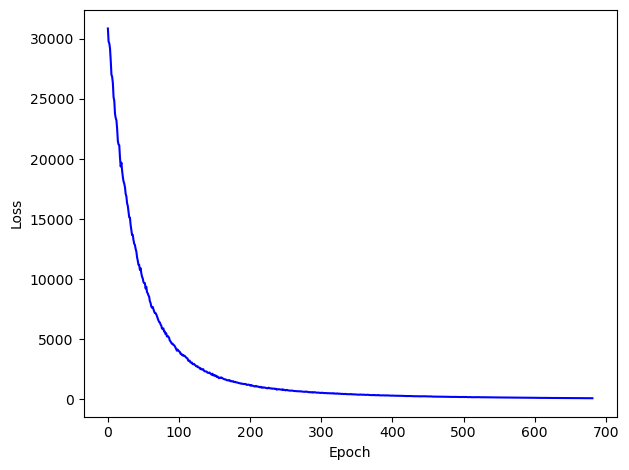

In [14]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()

/tmp/ipykernel_655801/1707345422.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_edge['IRT1_ability'] = ability.ravel()


Difficulty: PearsonRResult(statistic=-0.011276043202620926, pvalue=0.3855000808816393)
Age-Ability: PearsonRResult(statistic=0.8581137302558726, pvalue=0.0)
Ability: PearsonRResult(statistic=0.18508902955808687, pvalue=0.0)


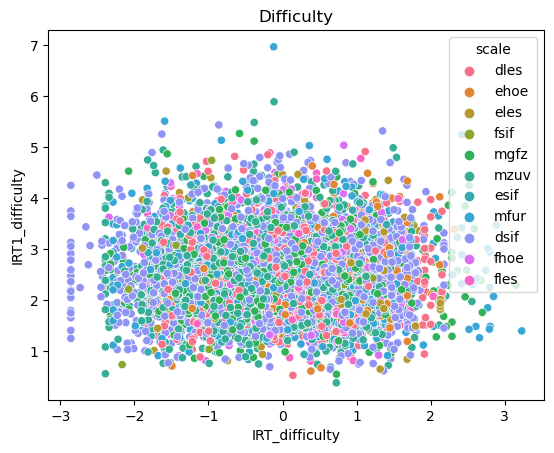

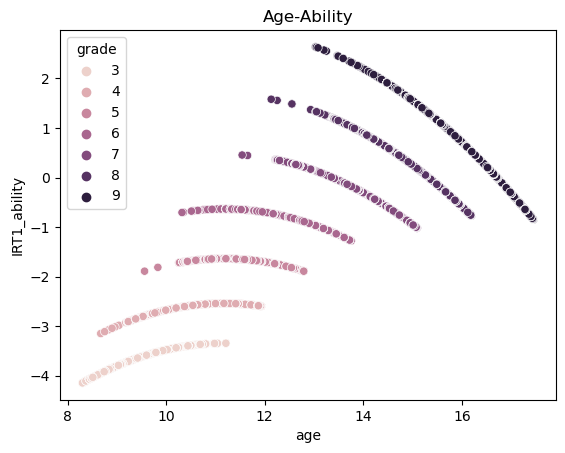

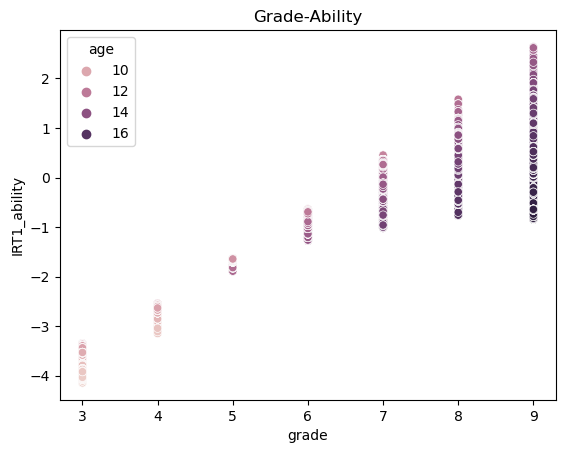

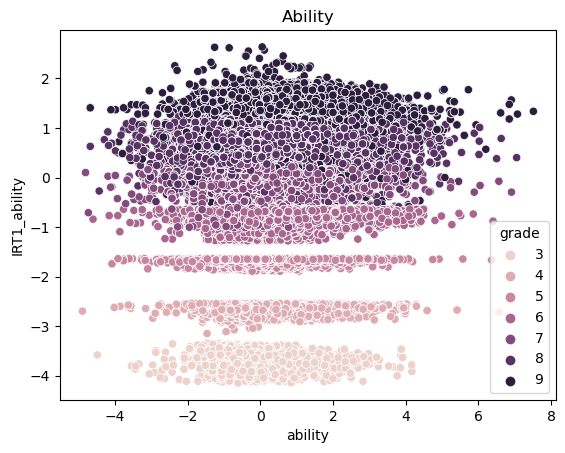

In [15]:
# save IRT parameters to matrix
if OUTNAME == 'IRT' and IRT_DIMS == 1:    
    #z_dict = model.get_embeddings(train_data.to(device))
    z_dict = output_dict['embedding_0']
    df_item['IRT1_difficulty'] = -z_dict['item']
    df_item['IRT1_discrimination'] = z_dict['offset']
    ability = z_dict['ability']
    df_edge['IRT1_ability'] = ability.ravel()
    
    aux_data = (df, df_student, df_item, df_edge, 
    train_losses, 
    train_edge_indices, val_edge_indices, test_edge_indices,
    data.cpu(), train_data.cpu(), val_data.cpu().cpu(), test_data.cpu(),
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

    with open(f'./results/{OUTNAME}_{DATASET}_aux_data_IRT1.pkl', 'wb') as handle:
        pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    df_item_clean = df_item.dropna(subset=['IRT_difficulty', 'IRT1_difficulty'])    
    
    fig = plt.figure()
    sns.scatterplot(x='IRT_difficulty', y='IRT1_difficulty', data=df_item, hue='scale')
    plt.title('Difficulty')
    print('Difficulty:', pearsonr(df_item_clean['IRT1_difficulty'], df_item_clean['IRT_difficulty']))
    
    edge_feat = train_data['student', 'responds', 'item'].edge_attr.detach().cpu().numpy()
    df_edge_clean = df_edge.dropna(subset=['IRT1_ability', 'ability', 'age'])
    fig = plt.figure()
    sns.scatterplot(x='age', y='IRT1_ability', data=df_edge_clean, hue='grade')
    plt.title('Age-Ability')
    
    fig = plt.figure()
    sns.scatterplot(x='grade', y='IRT1_ability', data=df_edge_clean, hue='age')
    plt.title('Grade-Ability')
    print('Age-Ability:', pearsonr(df_edge_clean['age'], df_edge_clean['IRT1_ability']))

    fig = plt.figure()
    sns.scatterplot(x='ability', y='IRT1_ability', data=df_edge_clean, hue='grade')
    plt.title('Ability')
    print('Ability:', pearsonr(df_edge_clean['ability'], df_edge_clean['IRT1_ability']))
    